<h1 style="font-size:3vw"> Analysis and forecast of institutional investors' positions </h1>

<div style="text-align: right"><q><i> Was it Mr Big, was it New York or was it me? </i></q></div>
<div style="text-align: right"> Carrie Bradshaw </div>

Программный код и размышления, используемые для написания курсовой работы.

# Импорт библиотек и загрузка данных

Импортирую библиотеки для обработки данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

import warnings
warnings.filterwarnings("ignore")

Считывание файла с данными. Он очень большой!

In [92]:
%%time
df = pd.read_csv(r'C:\Users\Redmi\Downloads\f13_data.csv')

Wall time: 3min 47s


В этом датасете много разных столбцов. Некоторые я до сих пор не понимаю.

In [3]:
df.columns

Index(['Unnamed: 0', 'stamp', 'access_id', 'other_manager',
       'investment_discretion', 'put_call', 'security_class',
       'ssh_prn_amt_type', 'acceptance_stamp', 'market_value', 'ssh_prn_amt',
       'voting_authority_sole', 'voting_authority_shared',
       'voting_authority_none', 'cik', 'conformed_submission_type',
       'conformed_period_of_report', 'filed_as_of_date', 'date_of_change',
       'effectiveness_date', 'fiscal_year_end', 'close', 'is_shifted_price',
       'id'],
      dtype='object')

Подгрузим таблицу соответствия CIK и наименования институционального инвестора. Таблица соответствия взята из базы <a href="https://www.sec.gov/Archives/edgar/cik-lookup-data.txt">EDGAR</a>.

In [4]:
cik_array = []

# Открываю файл
with open('cik-lookup-data.txt', 'r') as cik_data:
    
    # Создаю массив из пар "CIK - Название компании"
    for string in cik_data:
        if string:
            cik_array.append([string[:-13], int(string[-12:-2])])

# Перевожу массив в Dataframe
cik_lookup = pd.DataFrame(data=cik_array, columns=['fund_name', 'cik'])
cik_lookup.head()

,fund_name,cik
0,!J INC,1438823
1,"#1 A LIFESAFER HOLDINGS, INC.",1509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC,1457512
3,#1 PAINTBALL CORP,1433777
4,$ LLC,1427189


Теперь подгрузим таблицу соответствия тикера и его id. Таблица соответствия взята из базы <a href="https://www.sec.gov/include/ticker.txt">EDGAR</a>. С их помощью я через Yahoo! Finance я попытаюсь вычленить сектор каждой компании-эмитента, чтобы на его основе сгенерировать полезные для анализа переменные.

In [5]:
# Считываю таблицу соответствия
tickers_lookup = pd.read_csv('ticker.txt', sep='\t', names=['ticker', 'ticker_id'])
tickers_lookup.head()

,ticker,ticker_id
0,aapl,320193
1,msft,789019
2,amzn,1018724
3,goog,1652044
4,fb,1326801


Чтобы скачивать данные о секторе, я напишу специальную функцию.

In [6]:
# функция выгрузки секторов для набора тикеров
def extract_tickers_with_sector(symbols: list) -> pd.DataFrame :
    
    from yahooquery import Ticker
    
    # Получаю информацию из базы данных о тикерах
    tickers = Ticker(symbols, asynchronous=True)
    tickers = tickers.get_modules("summaryProfile quoteType")
    tickers = pd.DataFrame.from_dict(tickers).T
    
    # Преобразую информацию в понятный формат
    ticker_frames = [pd.json_normalize([x for x in tickers[module] if isinstance(x, dict)]) \
                                         for module in ['summaryProfile', 'quoteType']]
    
    # Оставляю необходимые столбцы
    tickers = pd.concat(ticker_frames, axis=1)[['symbol', 'sector']]
    # Для будущей пользы (и соответствия исходному формату) изменяю формат тикеров
    tickers.symbol = tickers.symbol.str.lower()

    return tickers

Теперь получу информацию о секторе.

In [10]:
%%time

# Формирую названия тикеров для функции
symbols = tickers_lookup.ticker.unique()
# Получаю значения секторов
tickers = extract_tickers_with_sector(symbols)
# Присоединяю данные о секторе к основной таблице
tickers = tickers.merge(tickers_lookup, left_on='symbol',
                        right_on='ticker', how='right', suffixes=(None, None))
# Удаляю ненужный столбец, по которому велось присоединение
tickers.drop('symbol', axis=1, inplace=True)

tickers.head()

Wall time: 6min 35s


,sector,ticker,ticker_id
0,Technology,aapl,320193
1,Technology,msft,789019
2,Consumer Cyclical,amzn,1018724
3,Communication Services,goog,1652044
4,Communication Services,fb,1326801


Я также заметил, что последняя буква (иногда и две) в написании тикеров часто соответствует типу финансового инструмента. Поэтому для тикеров с ненайденными секторами повторю процедуру, используя их в запросе без первой и второй буквы.

In [11]:
%%time

# Прохожу цикл по количеству убранных с конца букв
for last in (1, 2):
    # Составляю список правильных наименований тикеров без сектора для запроса
    symbols_without_sector = tickers[tickers.sector.isna()].ticker.str[:-last]
    # Получаю таблицу соответствия измененных названий тикеров и сектора
    res_for_symbols_without_sector = extract_tickers_with_sector(symbols_without_sector)
    # Составляю таблицу полных названий тикеров без названия и сектора
    sector_vals = symbols_without_sector.to_frame().merge(res_for_symbols_without_sector, how='left',
                                                          left_on='ticker', right_on='symbol').sector
    # Обновляю изначальную таблицу новыми соответствиями
    tickers.loc[tickers.sector.isna(), 'sector'] = sector_vals.values

# Изменяю пустые поля и отсутствия сектора на неопределенное значение
tickers['sector'] = tickers.sector.replace('', 'Undefined')
tickers['sector'] = tickers.sector.fillna('Undefined')
# Расширяю тип колонки идентификатора тикера для удобства сочленения с основными данными
tickers['ticker_id'] = tickers.ticker_id.astype('int64')

Wall time: 2min 13s


Посмотрим теперь на распределение секторов среди тикеров.

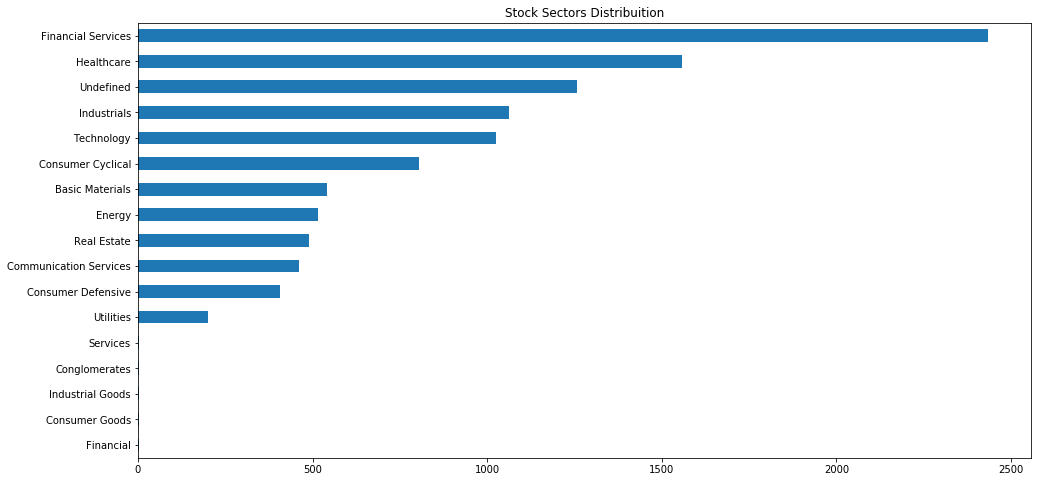

In [12]:
pl.figure(figsize=(16,8));
tickers.sector.value_counts().plot(kind='barh', title='Stock Sectors Distribuition').invert_yaxis();

Большинство компаний работают в секторах Здравоохранения и Финансовых услуг, а также в промышленности, IT и циклических индустрий. Замечу, что у нас огромная доля компаний не получила в соответствие сектор, что не очень приятно для дальнейшего анализа.

# Обработка датасета

Определяю количество лагов доли акции.

In [17]:
num_lags = 4

Чищу данные.

In [93]:
%%time
# оставляю только акции
df = df[df['security_class'] == "STOCK"]
# беру только самодостаточные активы
df = df[df['investment_discretion'] == "SOLE"]
# оставляю только обыкновенные акции с неразделимым правом на голосовании
df = df[(df['voting_authority_sole'] > 0) & (df['voting_authority_shared'] + df['voting_authority_none'] == 0)]
# Убираю наблюдения, которые являются опционами на акции
df = df[df['put_call'].isna()]

# Создаю переменную количества акций

# Создаю маску, указывающую, где стоит число акций
mask = (df['ssh_prn_amt_type'] == 'SH')
# Нахожу количество акций через отношение стоимости позиции и цены закрытия, если количество не было указано
df['shares'] = mask * df.ssh_prn_amt + (1 - mask) * df.market_value / df.close

# Почему-то в датасете есть позиции, на которых стоит нулевая стоимость или нулевое количество
df = df[df['shares'] > 0]
df = df[df['market_value'] > 0]

# перевожу дату в кварталы
df['period'] = pd.to_datetime(df.conformed_period_of_report).dt.to_period('Q')

# оставляю нужные колонки и перевожу в нужные форматы
df = df[['shares', 'market_value', 'cik', 'period', 'id', 'conformed_submission_type', 'close', 'stamp']].dropna()
df['shares'] = df['shares'].round()
df['ticker_id'] = df['id'].astype('int')
df['cik'] = df['cik'].astype('int')
df.drop('id', axis=1, inplace=True)

Wall time: 57.9 s


Теперь я хочу учесть влияние поправок к основным отчетам. Как сказано в сведениях, в поправках указываются окончательные позиции по активам. Значит, моя задача - оставить только поправки.

Во-первых, проверю, что в поправках указываются именно окончательные позиции, а изменения. Для этого посмотрю, нет ли отрицательных значений количества акций в наблюдениях поправок.

In [87]:
amends = df[df.conformed_submission_type == '13F-HR/A']
amends[amends.shares < 0].shape[0]

0

Так как в моих данных одной комбинации "Период - Тикер - Фонд" может соответствовать несколько наблюдений, как для основного отчета, так и для поправок, и эти наблюдения в отчете и поправках могут не совпадать, то я посчитаю суммы по комбинациям выше и типам отчета. Кроме того, так как фонды могут загружать основные отчеты и поправки в разное время, то я возьму тот тип отчета, который был загружен последним для каждой комбинации.

In [94]:
%%time

df = df.groupby(by=['cik', 'period', 'ticker_id', 'conformed_submission_type']).agg({'shares': 'sum',
                                                             'market_value': 'sum',
                                                             'stamp': 'max'}).reset_index()

df = df.sort_values(by='stamp').groupby(['cik', 'period', 'ticker_id']).last().reset_index()
df['_object'] = df.cik.apply(str) + '_' + df.ticker_id.apply(str) + '_' + df.period.apply(str)

Wall time: 13min 25s


Теперь постараюсь посмотреть, есть ли смысл использовать сектор компании для анализа вопроса. Посмотрим, какому количеству данных соответствует сектор.

In [96]:
# Привязываю данные о тикерах к основнуму датасету.
data = df.merge(tickers, how='left', on='ticker_id', suffixes=(None, None))

# Вывожу долю покрытия данными о тикерами
print(str(round(data[~data.ticker.isna()].shape[0] / data.shape[0] * 100, 3)) + '% covered by sectoral mapping')

0.392% covered by sectoral mapping


Как мы видим, соответствием в базе тикеров обладает меньше процента наблюдений. Поэтому я не буду включать данные о секторе в разработку модели.

Для красоты отсортирую данные и удобства отсортирую данные. 

In [97]:
%%time

# Сортирую данные
df = df.sort_values(by=['ticker_id', 'cik', 'period'])

Wall time: 14 s


In [192]:
# копирую датасет для возможности бэк-апа
final_df = df.copy(deep=True)

## Размер фондов

Сначала я создаю таблицу накопленной ценности инвестора в каждый квартал.

In [193]:
funds_value = final_df.groupby(by=['period', 'cik'])['market_value'].sum().reset_index()

Формирую пороговые значения низкой и высокой стоимости. Их я выбирал так, чтобы они примерно поровну делили выборку по размеру.

In [194]:
high_value = 3e8
low_value = 1e8

Рассмотрим некоторые основные описательные статистики.

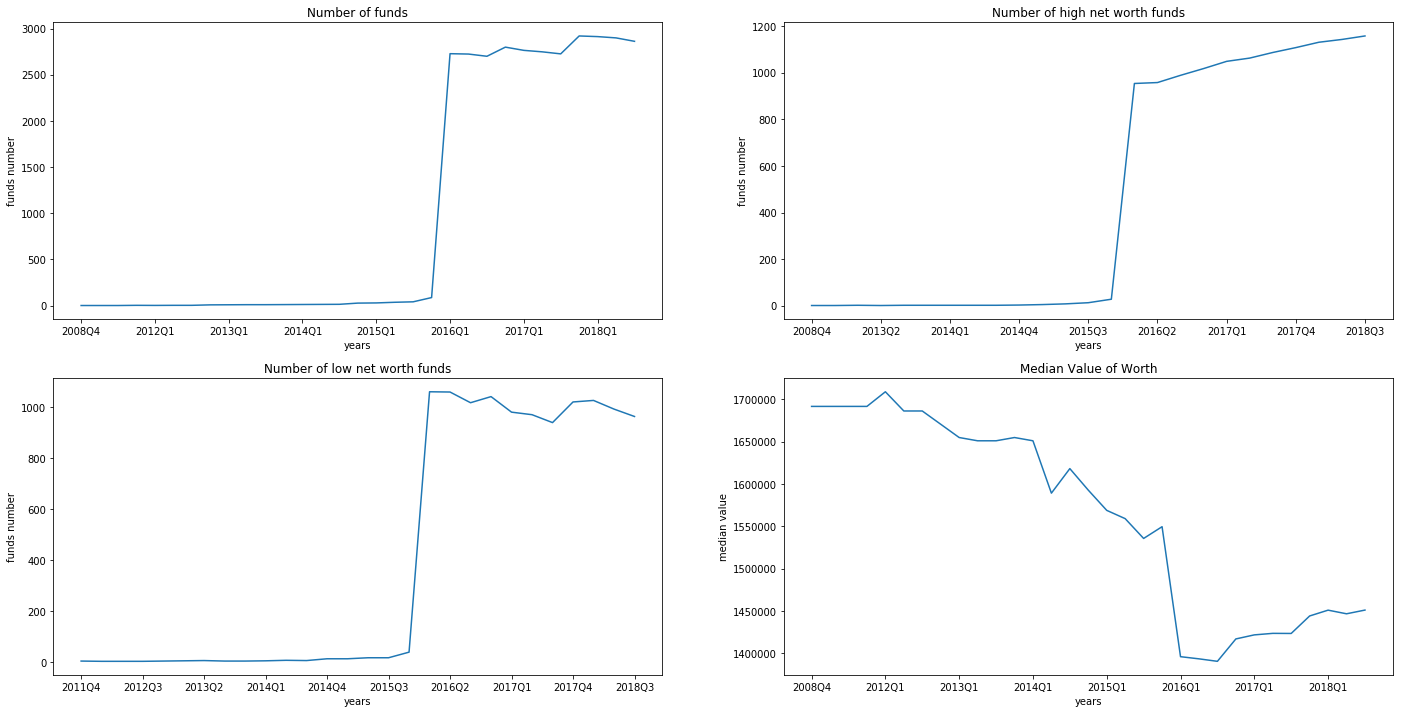

In [195]:
fig, axs = pl.subplots(2, 2, figsize=(24, 12));

plot_data = funds_value.groupby('period')['cik'].nunique()
axs[0, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 0].set_title('Number of funds');
axs[0, 0].set(xlabel='years', ylabel='funds number');
# axs[0, 0].tick_params(axis='x', labelsize=8);
axs[0, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value > high_value].groupby('period')['cik'].nunique()
axs[0, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 1].set_title('Number of high net worth funds');
axs[0, 1].set(xlabel='years', ylabel='funds number');
axs[0, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value < low_value].groupby('period')['cik'].nunique()
axs[1, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 0].set_title('Number of low net worth funds');
axs[1, 0].set(xlabel='years', ylabel='funds number');
axs[1, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value.groupby('period')['cik'].median()
axs[1, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 1].set_title('Median Value of Worth');
axs[1, 1].set(xlabel='years', ylabel='median value');
axs[1, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

Мы видим, что в нашем датасете до 2017 года фондов почти не было (их было меньше 100). Далее произошло резкое увеличение числа инвесторов, причем значительную их долю составили средние фонды, которые продолжают доминировать по количеству. Замеиим, что медианная стоимость упала в первом квартале 2016-го года, когда бурно увеличилось количество фондов в выборке. Это означает, что большинство пришедших фондов, несмотря на мое деление, были ближе к бедным, чем к богатым. Кроме того, в последнее время количество фондов в выборке уменьшилось. 

In [196]:
final_df = final_df[final_df.period >= '2016Q1']

Теперь я посмотрю на распределение ценности фондов.

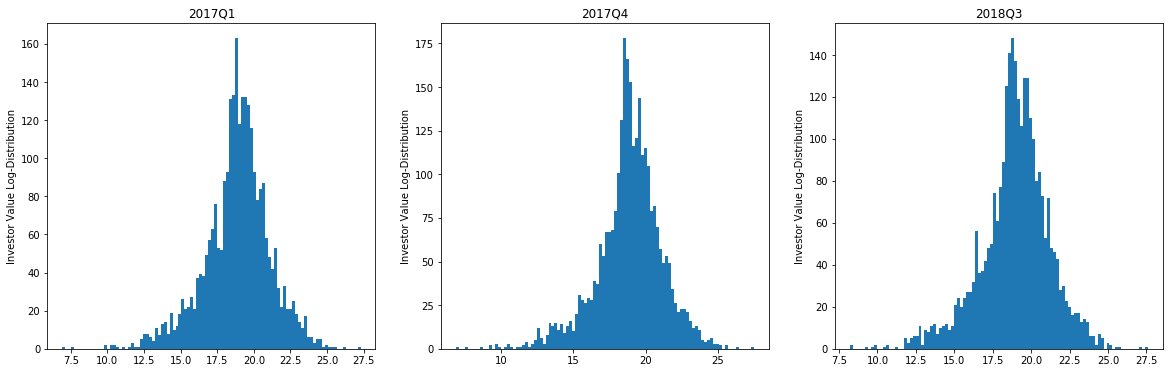

In [197]:
fig, axs = pl.subplots(1, 3, figsize=(20,6));

axs[0].hist(funds_value[funds_value.period == '2017Q1'].market_value.apply(np.log), bins=100);
axs[0].set_title('2017Q1');

axs[1].hist(funds_value[funds_value.period == '2017Q4'].market_value.apply(np.log), bins=100);
axs[1].set_title('2017Q4');

axs[2].hist(funds_value[funds_value.period == '2018Q3'].market_value.apply(np.log), bins=100);
axs[2].set_title('2018Q3');

for ax in axs.flat:
    ax.set(ylabel='Investor Value Log-Distribution')

Из графиков видно, что распределение незначительно изменялось за последние 2 года. Оно похоже на нормальное (то есть, если мы перейдем из логарифма к изначальным значениям, оно будет логнормальным. Только левый хвост у него больше, так как большинство фондов ближе к бедным, как говорилось выше.

Теперь создам дополнительные регрессоры.

In [198]:
final_df = final_df.merge(funds_value, on=['cik', 'period'], how='left', suffixes=('', '_fund'))
# Доля тикера в активах фонда поквартально
final_df['ticker_share'] = final_df.market_value / final_df.market_value_fund
# Логарифмирую ценность фонда как всякую денежную величину
final_df['log_value_fund'] = np.log(final_df.market_value_fund)
# Создаю индикаторные переменные, указывающие на принадлежность фонда к весовой категории
final_df['low_value'] = final_df.market_value_fund.le(low_value)
final_df['high_value'] = final_df.market_value_fund.ge(high_value)
final_df['med_value'] = ~(final_df['low_value'] + final_df['high_value'])

## Создание лагов регрессий

Создаю лаговые значения, связанные с акциями, для каждого наблюдения. Кроме того, создаю основную переменную, представляющую изменение количества акций тикера. Её я и буду предсказывать. Важно уточнить, что изменение считается от количества акций в предыдущем квартале.

In [199]:
%%time

# Считаю разницу кварталов, чтобы брать только те значения для лагов, которые из предыдущего квартала

# Иначе может выйти так, что я буду создавать лаги на наблюдение, которое было несколько кварталов назад
# Такая ситуация нам не нужна, так как это означает, что фирма тогда закончила инвестирование в эту акцию,
# а потом заново возобновила по другим, возможно, причинам, и начался новый цикл инвестирования в этот тикер
final_df['quarter_diff'] = final_df.period.dt.year * 4 + final_df.period.dt.quarter \
                - (final_df.period.dt.year * 4 + final_df.period.dt.quarter).shift()

# Добавлю индекс комбинации тикера и инвестора для удобства в агрегировании
df['object'] = df.ticker_id.apply(str) + '_' + df.cik.apply(str)

# Создаю лаги для количества акций и доли тикера в активах фонда
for lag in range(1, num_lags + 2):
    final_df['shares_lag' + '_' + str(lag)] = final_df.shares.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))
    final_df['ticker_share_lag' + '_' + str(lag)] = final_df.ticker_share.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))

# Создаю лаги для переменных размера фондов
    final_df['market_value_fund_lag' + '_' + str(lag)] = final_df.market_value_fund.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))    
    final_df['log_value_fund_lag' + '_' + str(lag)] = final_df.log_value_fund.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))
    final_df['low_value_lag' + '_' + str(lag)] = final_df.low_value.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))    
    final_df['high_value_lag' + '_' + str(lag)] = final_df.high_value.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))
    final_df['med_value_lag' + '_' + str(lag)] = final_df.med_value.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))

# Создаю предсказываю переменную и её лаги
for lag in range(1, num_lags + 1):
    final_df['net_shares_lag' + '_' + str(lag)] = final_df['shares_lag' + '_' + str(lag)]. \
                                                  div(final_df['shares_lag' + '_' + str(lag + 1)], axis=0).sub(1)

final_df['net_shares'] = final_df.shares.div(final_df['shares_lag' + '_' + str(1)], axis = 0).sub(1)

Wall time: 1min 9s


Теперь считаю лаги для переменных, связанных с размеров фонда, чтобы учесть изменение его размеров с течением времени.

In [200]:
%%time

for lag in range(1, num_lags + 1):
    final_df['size_cat_change_qrt_lag_' + str(lag)] = \
                    (final_df['high_value_lag_' + str(lag)] != final_df['high_value_lag_' + str(lag + 1)]) + \
                    (final_df['med_value_lag_' + str(lag)] != final_df['med_value_lag_' + str(lag + 1)]) + \
                    (final_df['low_value_lag_' + str(lag)] != final_df['low_value_lag_' + str(lag + 1)])
    
    final_df['size_cat_change_up_qrt_lag_' + str(lag)] = \
                    (final_df['high_value_lag_' + str(lag)] > final_df['high_value_lag_' + str(lag + 1)]) + \
                    (final_df['med_value_lag_' + str(lag)] > final_df['med_value_lag_' + str(lag + 1)])

final_df['size_cat_change_qrt'] = \
                    (final_df['high_value'] != final_df['high_value_lag_' + str(1)]) + \
                    (final_df['med_value'] != final_df['med_value_lag_' + str(1)]) + \
                    (final_df['low_value'] != final_df['low_value_lag_' + str(1)])

final_df['size_cat_change_up_qrt'] = \
                    (final_df['high_value'] > final_df['high_value_lag_' + str(1)]) + \
                    (final_df['med_value'] > final_df['med_value_lag_' + str(1)])

final_df['size_cat_change_total'] = False

for lag in range(1, num_lags + 1):
    final_df['size_cat_change_total'] += final_df['size_cat_change_qrt_lag_' + str(lag)]

Wall time: 7.97 s


Вот итоговые переменные.

In [201]:
final_df.head(10)

,cik,period,ticker_id,conformed_submission_type,shares,market_value,stamp,_object,object,market_value_fund,...,size_cat_change_up_qrt_lag_1,size_cat_change_qrt_lag_2,size_cat_change_up_qrt_lag_2,size_cat_change_qrt_lag_3,size_cat_change_up_qrt_lag_3,size_cat_change_qrt_lag_4,size_cat_change_up_qrt_lag_4,size_cat_change_qrt,size_cat_change_up_qrt,size_cat_change_total
0,5272,2016Q1,779,13F-HR,30681.0,859000.0,2016-05-12 11:28:14,5272_779_2016Q1,779_5272,2.289083e+10,...,False,True,False,True,False,True,False,True,False,True
1,5272,2016Q2,779,13F-HR,29955.0,824062.0,2016-08-11 11:38:08,5272_779_2016Q2,779_5272,2.356084e+10,...,False,True,False,True,False,True,False,False,False,True
2,5272,2016Q3,779,13F-HR,29922.0,862352.0,2016-11-09 17:23:48,5272_779_2016Q3,779_5272,2.500677e+10,...,False,True,False,True,False,True,False,False,False,True
3,5272,2016Q4,779,13F-HR,29473.0,974000.0,2017-02-10 16:37:45,5272_779_2016Q4,779_5272,2.577238e+10,...,False,False,False,True,False,True,False,False,False,True
4,5272,2017Q1,779,13F-HR,24875.0,879000.0,2017-05-10 16:46:13,5272_779_2017Q1,779_5272,2.635926e+10,...,False,False,False,False,False,True,False,False,False,True
5,5272,2017Q2,779,13F-HR,30773.0,1134000.0,2017-08-11 10:55:04,5272_779_2017Q2,779_5272,2.752555e+10,...,False,False,False,False,False,False,False,False,False,False
6,5272,2017Q3,779,13F-HR,32699.0,1127000.0,2017-11-09 11:55:01,5272_779_2017Q3,779_5272,2.809268e+10,...,False,False,False,False,False,False,False,False,False,False
7,5272,2017Q4,779,13F-HR,32818.0,1204000.0,2018-02-09 17:10:47,5272_779_2017Q4,779_5272,3.025178e+10,...,False,False,False,False,False,False,False,False,False,False
8,5272,2018Q1,779,13F-HR,26489.0,1033000.0,2018-05-07 16:26:05,5272_779_2018Q1,779_5272,2.840826e+10,...,False,False,False,False,False,False,False,False,False,False
9,5272,2018Q2,779,13F-HR,31682.0,1053000.0,2018-08-08 10:06:44,5272_779_2018Q2,779_5272,2.834944e+10,...,False,False,False,False,False,False,False,False,False,False


In [202]:
final_df.columns

Index(['cik', 'period', 'ticker_id', 'conformed_submission_type', 'shares',
       'market_value', 'stamp', '_object', 'object', 'market_value_fund',
       'ticker_share', 'log_value_fund', 'low_value', 'high_value',
       'med_value', 'quarter_diff', 'shares_lag_1', 'ticker_share_lag_1',
       'market_value_fund_lag_1', 'log_value_fund_lag_1', 'low_value_lag_1',
       'high_value_lag_1', 'med_value_lag_1', 'shares_lag_2',
       'ticker_share_lag_2', 'market_value_fund_lag_2', 'log_value_fund_lag_2',
       'low_value_lag_2', 'high_value_lag_2', 'med_value_lag_2',
       'shares_lag_3', 'ticker_share_lag_3', 'market_value_fund_lag_3',
       'log_value_fund_lag_3', 'low_value_lag_3', 'high_value_lag_3',
       'med_value_lag_3', 'shares_lag_4', 'ticker_share_lag_4',
       'market_value_fund_lag_4', 'log_value_fund_lag_4', 'low_value_lag_4',
       'high_value_lag_4', 'med_value_lag_4', 'shares_lag_5',
       'ticker_share_lag_5', 'market_value_fund_lag_5', 'log_value_fund_lag_5',

## Метрики стиля инвестирования

Сейчас я посмотрю на то, как фонды торгуют через призму стандартных метрик. С помощью этого я постараюсь добавить переменные, которые бы контролировали стиль фонда, ибо в зависимости от стиля инвестирования может меняться отношение к активам.

### Turnover и HHI

Считаю такие классные и потрясающие (реально же) метрики как turnover и индекс Херфиндаля-Хиршмана (HHI) для того, чтобы разграничить фонды по типам инвестирования и проводить контроль по ним. 

Сначала вычислю turnover.

In [203]:
turnover = final_df.fillna(0).groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_1']).sum()).reset_index()
turnover.rename(columns={0: 'turnover'}, inplace=True)
turnover.head()

,period,cik,turnover
0,2016Q1,2230,1.0
1,2016Q1,3520,1.0
2,2016Q1,5272,1.0
3,2016Q1,7789,1.0
4,2016Q1,8565,1.0


Теперь HHI.

In [204]:
hhi = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.square(x['ticker_share']).sum()).reset_index()
hhi.rename(columns={0: 'hhi'}, inplace=True)
hhi.head()

,period,cik,hhi
0,2016Q1,2230,0.017140
1,2016Q1,3520,0.017225
2,2016Q1,5272,0.010302
3,2016Q1,7789,0.045664
4,2016Q1,8565,0.648686


Теперь посмотрю на их распределение.

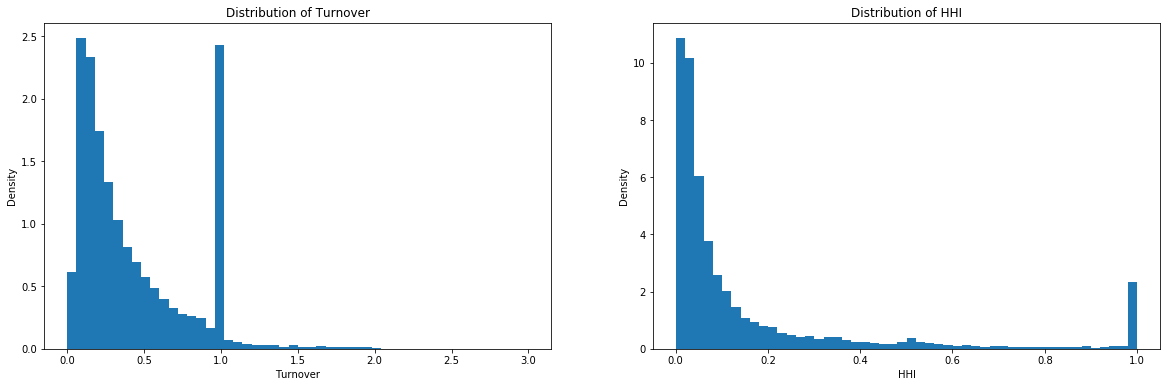

In [205]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].hist(turnover.turnover, density=True, bins=50, range=(0.001, 3));
axs[0].set_title('Distribution of Turnover');
axs[0].set(xlabel='Turnover', ylabel='Density');

axs[1].hist(hhi.hhi, density=True, bins=50, range=(0.001, 1));
axs[1].set_title('Distribution of HHI');
axs[1].set(xlabel='HHI', ylabel='Density');


Можно заметить, что их распределения похожи на геометрическое/Пуассона. Можно разграничить фонды по этим категориям, установив границы для каждого из критерия. Например, 0.5 для Turnover и 0.2 для HHI. Также отметим условно экстремальные ситуации, когда и Turnover, и HHI равны единице.

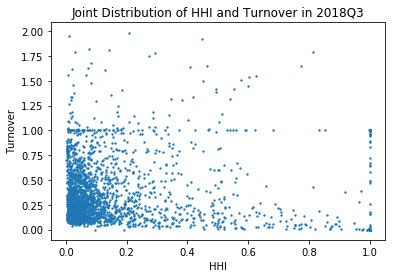

In [206]:
pl.scatter(hhi[hhi.period == final_df.period.max()].hhi, turnover[turnover.period == final_df.period.max()].turnover, s=1.8);
pl.xlabel('HHI');
pl.ylabel('Turnover');
pl.title('Joint Distribution of HHI and Turnover in ' + str(final_df.period.max()));

Если мы посмотрим на совместное их распределение, то не увидим каких-то кластеров. Но подозрительно выделяются наблюдения с HHI=1 (фонды с одной акцией). Вопрос - как такие фонды существуют/как они попали к нам в выборку? Установим контроль и на них.

Добавляю переменные на основе наблюдений.

In [207]:
# Добавляю сами индексы
final_df = final_df.merge(turnover, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(hhi, on=['cik', 'period'], how='left', suffixes=(False, False))

# Устанавливаю контроль на фонды с одной акцией
final_df['hhi_eq_1'] = final_df.hhi.eq(1)
final_df['tvr_eq_1'] = final_df.turnover.eq(1)

# Разграничиваю фонды по метрикам через индикаторы
final_df['high_hhi'] = final_df.hhi > .2
final_df['high_turnover'] = final_df.turnover > .5

Если мы посмотрим на совместное распределение Размера фонда и наших метрик, то опять не увидим каких-либо кластеров, по которым можно было бы провести классификацию. Печаль.

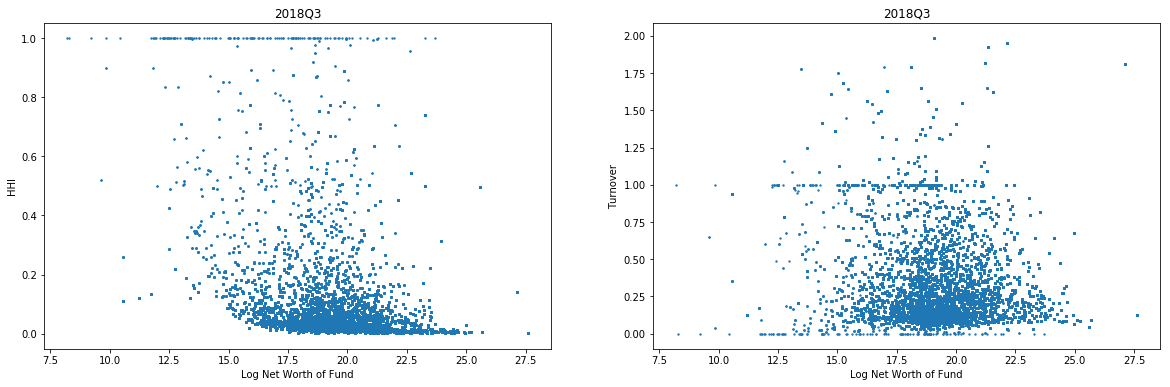

In [208]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].scatter(final_df[final_df.period == final_df.period.max()].log_value_fund,
           final_df[final_df.period == final_df.period.max()].hhi, s=1.8);
axs[0].set_title(final_df.period.max());
axs[0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[1].scatter(final_df[final_df.period == final_df.period.max()].log_value_fund,
           final_df[final_df.period == final_df.period.max()].turnover, s=1.8);
axs[1].set_title(final_df.period.max());
axs[1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

Тем не менее, при достаточной фантазии мы можем представить, что большинство значений находится в эллипсе с центром в точке (20, 0) и с радиусами 0.4 для HHI и 1.2 для Turnover. Также осуществим контроль на экстремальные значения turnover > 1.4. Они выбиваются из общей картины.

In [209]:
final_df['extreme_turnover'] = final_df.turnover > 1.4
final_df['cluster_hhi'] = (np.square(final_df.hhi) + np.square(final_df.log_value_fund - 20) > (0.4 ** 2))
final_df['cluster_turnover'] = (np.square(final_df.turnover) + 4 * np.square(final_df.log_value_fund - 20) > (1.0 ** 2))

Теперь я посмотрю на совместное распределение с зависимой переменной изменения количества акций, чтобы лучше понять зависимость от класса фонда.

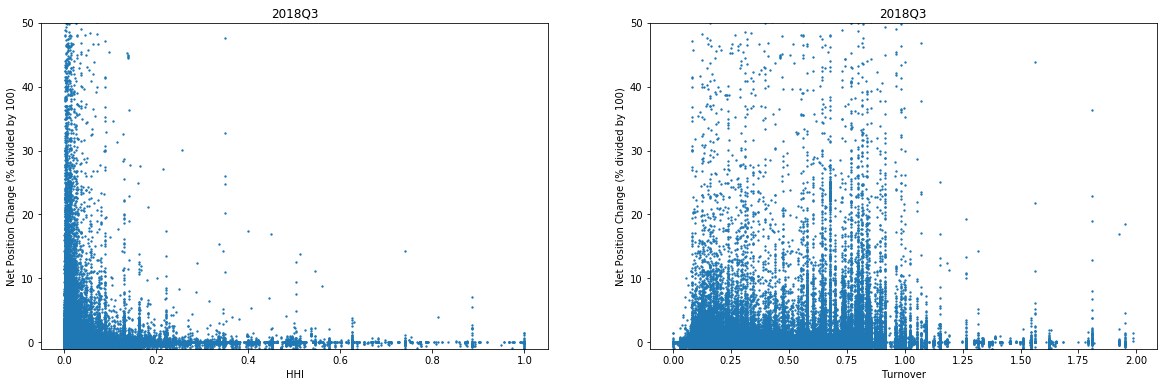

In [210]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].scatter(final_df[final_df.period == final_df.period.max()].hhi,
           final_df[final_df.period == final_df.period.max()].net_shares, s=1.8);
axs[0].set_title(final_df.period.max());
axs[0].set(xlabel='HHI', ylabel='Net Position Change (% divided by 100)');
axs[0].set_ylim(-1, 50);

axs[1].scatter(final_df[final_df.period == final_df.period.max()].turnover,
           final_df[final_df.period == final_df.period.max()].net_shares, s=1.8);
axs[1].set_title(final_df.period.max());
axs[1].set(xlabel='Turnover', ylabel='Net Position Change (% divided by 100)');
axs[1].set_ylim(-1, 50);

Из графиков можно увидеть обратную зависимость от HHI. Возможно, стоит в регрессию добавить регрессор в виде обратного HHI. Получается, чем больше у фонда акций, тем меньше он будет менять их позиции. Это связано с тем, что фонды, у которых много акций, часто являются индексными или квантовыми, из-за чего там часто происходят значительные перекалибровки позиций. Зависимость от Turnover неочевидна. У нас много наблюдений с Turnover не больше 1, в которых не видна зависимость. Даже разброс значений примерно одинаков. Аналогичная ситуация с Turnover больше 1.

Создам теперь переменную обратного HHI.

In [211]:
final_df['hhi_rev'] = 1 / final_df.hhi

### Количество акций в портфеле

Сейчас я посмотрю на то, как соотносится количество акций в портфеле с его размером и метриками, расмотренными выше.

Сначала я создам таблицу с данными о количестве позиций у фондов.

In [212]:
# Создаю таблицу количества позиций из агрегированных данных
pos_count = final_df.groupby(['period', 'cik']).count().reset_index()[['period', 'cik', 'shares']]
pos_count.rename(columns={'shares': 'pos_count'}, inplace=True)

pos_count.head()

,period,cik,pos_count
0,2016Q1,2230,76
1,2016Q1,3520,363
2,2016Q1,5272,2990
3,2016Q1,7789,70
4,2016Q1,8565,2


Теперь добавляю эти данные в датасет и пролаггирую их, так как, опять же, нам не доступны данные из периода предсказания.

In [213]:
# Присоединяю новые данные
final_df = final_df.merge(pos_count, on=['period', 'cik'], how='left', suffixes=(False, False))
# Создаю лаг количества тикеров в фонде
final_df['pos_count_lag' + '_' + str(1)] = final_df.pos_count.shift(periods=1). \
                                              where((final_df.object == final_df.object.shift(periods=1)) &
                                                    (final_df.quarter_diff == 1))

Теперь посмотрим на распределение количества позиций в фонде.

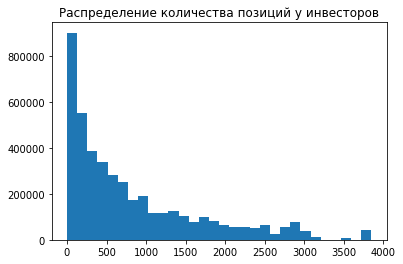

In [214]:
pl.hist(final_df.pos_count, bins=30);
pl.title('Распределение количества позиций у инвесторов');

Мы видим, что распределение фондов похоже на геометрическое. Тогда разобьем его на классы последовательным извлечением половины. В первом классе будут фонды с количеством позиций, большим 2000. Во втором классе - большим 1000. И в третьем - большим 200. Это не деление по половине, но по гистограмме видно, что количество фондов с количеством позиций, меньшим 200, выбивает из сглаженности распределения, что я воспринимаю как сигнал, чтобы сместить границу разделения. Также я отмечу фонды с количеством позиций, большим 3000 и собирают почти все акции на рынке. Они стоят особняком от основного распределения. Вполне возможно, что те самые индексные и квантовые фонды, которые работают по всей вселенной акций.

In [215]:
final_df['extreme_pos_count'] = final_df.pos_count_lag_1 > 3000
final_df['high_pos_count'] = final_df.pos_count_lag_1 > 2000
final_df['med_pos_count'] = final_df.pos_count_lag_1 > 1000
final_df['up_low_pos_count'] = final_df.pos_count_lag_1 > 200

Теперь я посмотрю на совместное распределение корня числа позиций и логарифма ценности фонда.

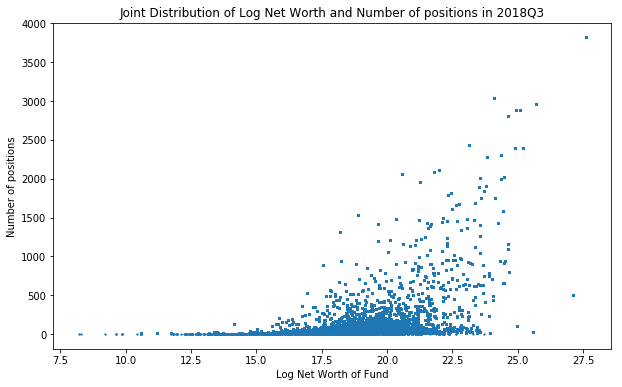

In [216]:
fig, axs = pl.subplots(1, 1, figsize=(10,6));

axs.scatter(final_df[final_df.period == final_df.period.max()].log_value_fund,
            final_df[final_df.period == final_df.period.max()].pos_count, s=1.8);
axs.set_title('Joint Distribution of Log Net Worth and Number of positions in ' + str(final_df.period.max()));
axs.set(xlabel='Log Net Worth of Fund', ylabel='Number of positions');

Здесь сложно выделить кластеры, но я предположу, что можно разделить наблюдения на две части по прямой, которая отсечет участок наблюдений с высокой плотностью в нижней части графика от участка с низкой плотностью в верхней. Если подумать, то при применении к размеру фонда функции корня в определенной степени, то мы получим линейную зависимость на некотором участке.

In [217]:
final_df['cluster_size_pos'] = (final_df.pos_count > 1000 - 40 * final_df.log_value_fund)

Теперь я посмотрю на распределения корня числа позиций относительно HHI и Turnover.

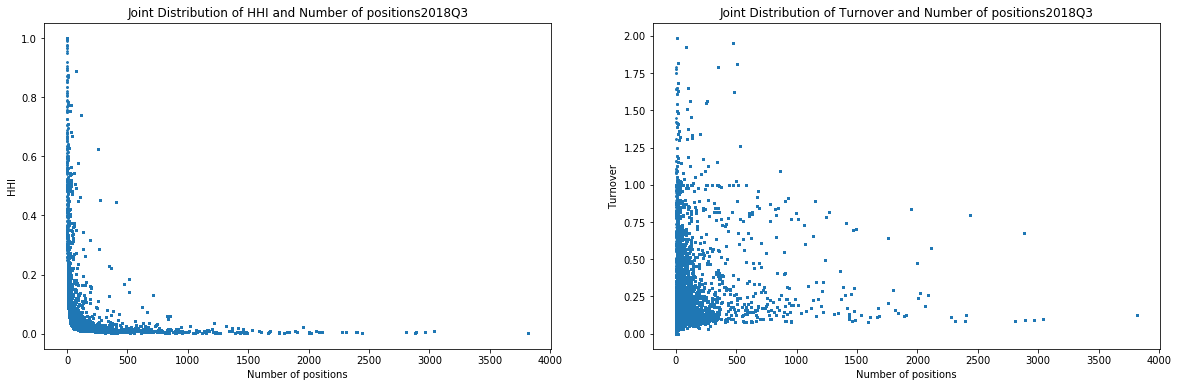

In [218]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].scatter(final_df[final_df.period == final_df.period.max()].pos_count,
           final_df[final_df.period == final_df.period.max()].hhi, s=1.8);
axs[0].set_title('Joint Distribution of HHI and Number of positions' + str(final_df.period.max()));
axs[0].set(xlabel='Number of positions', ylabel='HHI');

axs[1].scatter(final_df[final_df.period == final_df.period.max()].pos_count,
           final_df[final_df.period == final_df.period.max()].turnover, s=1.8);
axs[1].set_title('Joint Distribution of Turnover and Number of positions' + str(final_df.period.max()));
axs[1].set(xlabel='Number of positions', ylabel='Turnover');

Можно заметить, что большинство значений на первом графике лежат ниже некоторой границы гиперболического вида, а на втором - ниже некоторой линейной границы. Я приблизительно их определю и добавлю на индикаторы на превышение этих границ.

In [219]:
final_df['cluster_pos_hhi'] = (final_df.hhi > 20 / final_df.pos_count)

После всех приготовлений избавлюсь от ненужных наблюдений и столбцов.

In [220]:
# Избавляюсь от ненужных колонок и наблюдений
final_df.drop(['shares_lag_5', 'ticker_share_lag_5', 'quarter_diff',
              'market_value_fund', 'ticker_share'], axis=1, inplace=True)

## Variables Factoring

Теперь я факторизирую (<a href="https://www.stata.com/manuals13/u25.pdf">Variable Factoring</a>, не знаю, как лучше перевести, кросс-перемножу) непрерывные переменные Turnover, прямого и обратнго HHI, так как я считаю, что в зависимости от размера и инвестиционного стиля будет меняться поведение фонда.

In [221]:
# Факторизирую turnover и HHI
final_df['turnover' + '_high'] = final_df['turnover'].mul(final_df.high_value, axis=0)
final_df['turnover' + '_med'] = final_df['turnover'].mul(final_df.med_value, axis=0)
final_df['turnover' + '_low'] = final_df['turnover'].mul(final_df.low_value, axis=0)

final_df['hhi' + '_high'] = final_df['hhi'].mul(final_df.high_value, axis=0)
final_df['hhi' + '_med'] = final_df['hhi'].mul(final_df.med_value, axis=0)
final_df['hhi' + '_low'] = final_df['hhi'].mul(final_df.low_value, axis=0)

final_df['hhi_rev' + '_high'] = final_df['hhi_rev'].mul(final_df.high_value, axis=0)
final_df['hhi_rev' + '_med'] = final_df['hhi_rev'].mul(final_df.med_value, axis=0)
final_df['hhi_rev' + '_low'] = final_df['hhi_rev'].mul(final_df.low_value, axis=0)

Также я добавлю переменную среднего значения изменения позиции тикера по всем фондам и по фондам одной весовой категории, а также среднее значение изменения по другим активам фонда, чтобы учесть, как рынок (инвесторы) и сходие по размеру фонды в целом реагировали на ситуацию.

In [223]:
%%time

# Составляю таблицы средних изменений позиций по тикеру, периоду и фонду

mean_net_shares = final_df.groupby(['ticker_id', 'period'])['net_shares'].mean().reset_index()
mean_net_shares.rename(columns={'net_shares': 'mean_net_shares'}, inplace=True)

mean_net_shares_by_cik = final_df.groupby(['cik', 'period'])['net_shares'].mean().reset_index()
mean_net_shares_by_cik.rename(columns={'net_shares': 'mean_net_shares_by_cik'}, inplace=True)

mean_net_shares_by_value = final_df.groupby(['ticker_id', 'period', 'high_value', 'med_value']) \
                                                        ['net_shares'].mean().reset_index()
mean_net_shares_by_value.rename(columns={'net_shares': 'mean_net_shares_by_value'}, inplace=True)

# Сцепляю их с нашим датасетом

final_df = final_df.merge(mean_net_shares, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_shares_by_cik, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_shares_by_value, on=['ticker_id', 'period', 'high_value', 'med_value'],
                                                                  how='left', suffixes=(False, False))

# Считаю количество фондов, владеющих тикером в каждом периоде, чтобы вычесть потом долю отдельного фонда в среднем по тикеру

tickers_count = final_df.groupby(['ticker_id', 'period']).count().reset_index()
tickers_count_by_value = final_df.groupby(['ticker_id', 'period', 'high_value', 'med_value'])\
                                                            .count().reset_index()

tickers_count.rename(columns={'shares': 'tickers_count'}, inplace=True)
tickers_count_by_value.rename(columns={'shares': 'tickers_count_by_value'}, inplace=True)

final_df = final_df.merge(tickers_count[['ticker_id', 'period', 'tickers_count']], on=['ticker_id', 'period'],
                                                                                          how='left', suffixes=(False, False))
final_df = final_df.merge(tickers_count_by_value[['ticker_id', 'period', 'high_value', 'med_value', 'tickers_count_by_value']], 
                                                                        on=['ticker_id', 'period', 'high_value', 'med_value'],
                                                                                          how='left', suffixes=(False, False))

# Вычитаю из среднего по тикеру составляющую конкретного фонда в нем для каждого наблюдения
# Тем самым, я получаю среднее по всем остальным фондам

final_df['mean_net_shares'] -= final_df.net_shares.div(final_df.tickers_count, axis=0).values
final_df['mean_net_shares_by_cik'] -= final_df.net_shares.div(final_df.pos_count, axis=0).values
final_df['mean_net_shares_by_value'] -= final_df.net_shares.div(final_df.tickers_count_by_value, axis=0).values

Wall time: 7min 57s


## Макро

Я предполагаю, что инвесторы обращают внимание на макроэкономическую ситуацию и её изменение <i>(иначе зачем макроэкономику преподают и изучают)</i>, чтобы исправлять свои стратегии.

<b> Поэтому я считаю, что важно проконтролировать изменение макроэкономических параметров в модели, так как без этого их влияние войдет в остаток, а я хочу, чтобы в остатках лежало только настроение фонда относительно тикера, определяемое его новыми инсайтами, а не экзогенными факторами. </b>

Я буду пользоваться парсером pandas, чтобы получать данные из статистической службы FRED.

В качестве переменных я собираюсь использовать поквартальное изменение ключевой ставки, ставки по десятилетним казначейским облигациям, уровню инфляции и росту ВВП (последние два тоже поквартальные).

In [57]:
import pandas_datareader as wb

In [59]:
# скачиваю ставки и нахожу их изменение, группируя по кварталам
rates = wb.DataReader(['DGS10', 'DFF', 'UNRATE'], 'fred', start=2012).resample('Q-DEC').mean().diff() / 100
rates.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
rates.DATE = rates.DATE.dt.to_period('Q')

In [60]:
# Нахожу инфлцяцию через Индекс потребительских цен, группируя по кварталам
inflation = wb.DataReader('CPIAUCSL', 'fred', start=2012).resample('Q-DEC').mean().pct_change()
inflation.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
inflation.DATE = inflation.DATE.dt.to_period('Q')

In [61]:
# Скачиваю данные по ВВП и считаю рост (а тут сразу всё поквартально!)
gdp_growth = wb.DataReader('GDP', 'fred', start=2012).pct_change()
gdp_growth.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
gdp_growth.DATE = gdp_growth.DATE.dt.to_period('Q')

In [ ]:
%%time

# Связываю полученные значения с нашим датасетом

final_df = final_df.merge(rates, left_on='period', right_on='DATE', how='left', suffixes=(False, False))
final_df = final_df.merge(inflation, on="DATE", how='left', suffixes=(False, False))
final_df = final_df.merge(gdp_growth, on="DATE", how='left', suffixes=(False, False))
final_df.drop('DATE', axis=1, inplace=True)

Предположу, что фонд будет по-разному реагировать на изменение макроэкономического положения в зависимости от своего размера. Поэтому факторизую индикаторы и построю на новых переменных регрессию.

In [68]:
for macro_factor in ['DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']:
    final_df[macro_factor + '_high'] = final_df[macro_factor].mul(final_df.high_value, axis=0)
    final_df[macro_factor + '_med'] = final_df[macro_factor].mul(final_df.med_value, axis=0)
    final_df[macro_factor + '_low'] = final_df[macro_factor].mul(final_df.low_value, axis=0)

## Формирование датасетов для отдельных задач

Так как у многих активов в фондах может не хватать старших лагов, а также учитывая, что фонды не всегда вкладываются на долгий срок, то я для каждого количества доступных лагов, идущих подряд, начиная с первого, создам отдельный датасет, на котором я буду проводить отдельные испытания моделей. В итоге, у меня будет 4 датасета, в первом будут значения для первого лага, во втором - для первого и второго, и так далее.

Также, я создам 5-й датасет, где не будет ни одного лага, и я на нем буду решать задачу предсказания появления позиции по акции в фонде.

Кроме того, я хочу создать датасет, который бы помогал решить задачу определения ситуаций, когда фонд выходит из тикера, но создание такого датасета представляется чересчур ресурсозатратным, так как мой датасет знает только ситуации, когда фонд владел акциями. Плюс, я не всегда знаю, была ли в обороте та или иная акция в определенный квартал, которая не была ни в одном фонде в тот квартал, но есть в датасете.

In [24]:
%%time

lag0 = final_df[(final_df.shares_lag_1.isna()) * final_df.shares_lag_2.isna() * \
            final_df.shares_lag_3.isna() * final_df.shares_lag_4.isna()].dropna()
lag1 = final_df[(~final_df.shares_lag_1.isna()) * final_df.shares_lag_2.isna() * \
            final_df.shares_lag_3.isna() * final_df.shares_lag_4.isna()].dropna()
lag2 = final_df[~final_df.shares_lag_1.isna() * (~final_df.shares_lag_2.isna()) * \
            final_df.shares_lag_3.isna() * final_df.shares_lag_4.isna()].dropna()
lag3 = final_df[(~final_df.shares_lag_1.isna()) * (~final_df.shares_lag_2.isna()) * \
            (~final_df.shares_lag_3.isna()) * final_df.shares_lag_4.isna()].dropna()
lag4 = final_df[(~final_df.shares_lag_1.isna()) * (~final_df.shares_lag_2.isna()) * \
            (~final_df.shares_lag_3.isna()) * (~final_df.shares_lag_4.isna())].dropna()

Wall time: 1min 39s


# Совершаем простейшие регрессии (через МНК)

Теперь, когда я определился с переменными, попробую определить характер зависимости чистого изменения позиции от регрессоров. Для красоты представления буду пользоваться библиотекой <i>statsmodels<i/>. Начну с простой модели без факторизации.

### Модель 1

In [13]:
import statsmodels.api as sm

In [26]:
y = lag4['net_shares']

X = lag4[['log_value_fund',
       'high_value', 'med_value',
       'ticker_share_lag_1', 'ticker_share_lag_2', 'ticker_share_lag_3', 'ticker_share_lag_4',
       'net_shares_lag_1', 'net_shares_lag_2', 'net_shares_lag_3', 'net_shares_lag_4',
       'size_cat_change_qrt_lag_1', 
       'size_cat_change_up_qrt_lag_1', 'size_cat_change_qrt_lag_2',
       'size_cat_change_up_qrt_lag_2', 'size_cat_change_qrt_lag_3',
       'size_cat_change_up_qrt_lag_3', 'size_cat_change_qrt_lag_4',
       'size_cat_change_up_qrt_lag_4', 'size_cat_change_qrt',
       'size_cat_change_up_qrt', 'size_cat_change_total',
       'turnover', 'hhi', 'hhi_eq_1', 'tvr_eq_1', 'high_hhi',
       'high_turnover', 'extreme_turnover', 
       'cluster_hhi', 'cluster_turnover', 'hhi_rev', 'pos_count',
       'extreme_pos_count', 'high_pos_count', 'med_pos_count', 'up_low_pos_count',
       'cluster_size_pos', 'cluster_pos_hhi', 'mean_net_shares', 'mean_net_shares_by_cik',
       'mean_net_shares_by_value']].astype('float64')
X = sm.add_constant(X)

В этой модели я учитываю величину активов фонда, лаги чистых изменений позиций, переменные, связанные с turnover и hhi, и среднее по остальным фондам.

Делаю первую модель. Простой метод наименьших квадратов.

In [27]:
model_1 = sm.OLS(y, X).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     2984.
Date:                Sun, 06 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:00:49   Log-Likelihood:            -9.7462e+06
No. Observations:             1298404   AIC:                         1.949e+07
Df Residuals:                 1298362   BIC:                         1.949e+07
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.2084      7.333      0.028      0.977     -14.164      14.581
log_value_fund                   0.0364      0.445      0.082      0.935      -0.836       0.909
high_value                      -2.8107      2.478     -1.134      0.257      -7.668       2.046
med_value                        0.5699      1.879      0.303      0.762      -3.113       4.252
ticker_share_lag_1            -131.5809     39.379     -3.341      0.001    -208.763     -54.398
ticker_share_lag_2              43.1104     48.357      0.891      0.373     -51.669     137.889
ticker_share_lag_3              24.8585     48.930      0.508      0.611     -71.042     120.759
ticker_share_lag_4              63.3156     38.834      1.630      0.103     -12.797     139.428
net_shares_lag_1                -0.0026      0.001     -3.295      0.001      -0.004      -0.001
net_shares_lag_2                -0.0039      0.002     -2.324      0.020      -0.007      -0.001
net_shares_lag_3                 0.0034      0.001      2.970      0.003       0.001       0.006
net_shares_lag_4                 0.0082      0.001      7.324      0.000       0.006       0.010
size_cat_change_qrt_lag_1       -8.0863      5.925     -1.365      0.172     -19.698       3.526
size_cat_change_up_qrt_lag_1    -4.6653      6.294     -0.741      0.459     -17.000       7.670
size_cat_change_qrt_lag_2       -2.8763      5.670     -0.507      0.612     -13.990       8.238
size_cat_change_up_qrt_lag_2     6.4202      6.124      1.048      0.294      -5.582      18.423
size_cat_change_qrt_lag_3       -4.9707      5.845     -0.850      0.395     -16.426       6.485
size_cat_change_up_qrt_lag_3    -2.7709      6.217     -0.446      0.656     -14.956       9.414
size_cat_change_qrt_lag_4       -7.2064      5.663     -1.273      0.203     -18.305       3.892
size_cat_change_up_qrt_lag_4    -4.9323      5.846     -0.844      0.399     -16.391       6.526
size_cat_change_qrt              0.2330      5.791      0.040      0.968     -11.118      11.584
size_cat_change_up_qrt          -0.2833      6.385     -0.044      0.965     -12.798      12.231
size_cat_change_total           12.1248      3.363      3.605      0.000       5.533      18.717
turnover                        -2.0170      3.737     -0.540      0.589      -9.341       5.307
hhi                              6.2614     14.752      0.424      0.671     -22.653      35.176
hhi_eq_1                         6.5717     29.617      0.222      0.824     -51.476      64.619
tvr_eq_1                     -1.205e-11   1.77e-11     -0.682      0.495   -4.67e-11    2.26e-11
high_hhi                        -0.1082      5.453     -0.020      0.984     -10.796      10.580
high_turnover                    3.1122      2.412      1.290      0.197    

Константа сразу нормальная. Значимы только лаги изменений и изменение размера, а также все средние изменения!!!!!!

Зависимость от размера положительная, как и от HHI, но отрицательна от обратного HHI и Turnover.

Изменение размера влияет отрицательно почти всегда для каждого квартала, но его наличие в общем случае влияет положительно.

Значения различаются по масштабу.

В результатах написано, что присутствует сильная мультиколлинеарность, но она нас не волнует, так как не влияет на состоятельность оценок.

Создаю меру настроя инвесторов. То, ради чего затевалась курсовая.

In [28]:
# Наша искомая переменная!
delta_1 = y - model_1.predict(X)

Посмотрим на её зависимость от величины активов. Предполагается, что будет наблюдаться некоторая зависимость.

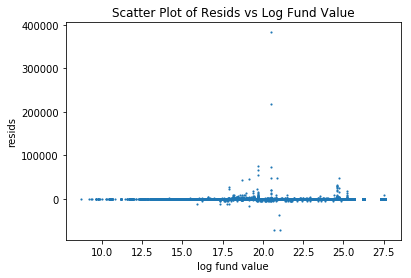

In [30]:
pl.scatter(X.log_value_fund, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Log Fund Value');
pl.xlabel('log fund value');
pl.ylabel('resids');

Как можно увидеть, никакой зависимости нет, дисперсия примерно везде одинакова. Она заметно выше в определенных районах, но мне кажется, это из-за того, что в этих диапазонах просто больше наблюдений, поэтому разброс чуть повыше.

На графике видно, что остатки какие-то выдающиеся. Посмотрю на гистограмме, есть ли у меня такие наблюдения.

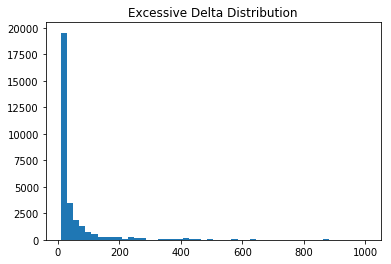

In [37]:
pl.hist(delta_1, bins=50, range=(10, 1000));
pl.title('Excessive Delta Distribution');

Да, есть много наблюдений, где оценка отличается больше, чем на 1000 процентнов. Вероятно, это из-за того, что в нашей выборке много около-бедных фондов, которые при начале инвестирования в тикер быстро наращивают вложения. При этом, из-за своих возможностей они не могут покупать много акций, из-за чего при постепенном увеличении вложений процентное изменение оказывается невероятно высоким. Это проблема масштаба, как проблема сходимости экономического роста в неразвитых и развитых странах.

Чтобы избавиться от этой проблемы, я нормализую зависимую переменную. Посмотрим, станет ли лучше.

### Модель 2

In [38]:
y = (y - y.mean()) / y.std()

In [39]:
model_2 = sm.OLS(y, X).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     2984.
Date:                Sun, 06 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:06:41   Log-Likelihood:            -1.7839e+06
No. Observations:             1298404   AIC:                         3.568e+06
Df Residuals:                 1298362   BIC:                         3.568e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.0036      0.016     -0.226      0.821      -0.035       0.028
log_value_fund                7.903e-05      0.001      0.082      0.935      -0.002       0.002
high_value                      -0.0061      0.005     -1.134      0.257      -0.017       0.004
med_value                        0.0012      0.004      0.303      0.762      -0.007       0.009
ticker_share_lag_1              -0.2857      0.086     -3.341      0.001      -0.453      -0.118
ticker_share_lag_2               0.0936      0.105      0.891      0.373      -0.112       0.299
ticker_share_lag_3               0.0540      0.106      0.508      0.611      -0.154       0.262
ticker_share_lag_4               0.1375      0.084      1.630      0.103      -0.028       0.303
net_shares_lag_1             -5.607e-06    1.7e-06     -3.295      0.001   -8.94e-06   -2.27e-06
net_shares_lag_2             -8.552e-06   3.68e-06     -2.324      0.020   -1.58e-05   -1.34e-06
net_shares_lag_3              7.281e-06   2.45e-06      2.970      0.003    2.48e-06    1.21e-05
net_shares_lag_4              1.789e-05   2.44e-06      7.324      0.000    1.31e-05    2.27e-05
size_cat_change_qrt_lag_1       -0.0176      0.013     -1.365      0.172      -0.043       0.008
size_cat_change_up_qrt_lag_1    -0.0101      0.014     -0.741      0.459      -0.037       0.017
size_cat_change_qrt_lag_2       -0.0062      0.012     -0.507      0.612      -0.030       0.018
size_cat_change_up_qrt_lag_2     0.0139      0.013      1.048      0.294      -0.012       0.040
size_cat_change_qrt_lag_3       -0.0108      0.013     -0.850      0.395      -0.036       0.014
size_cat_change_up_qrt_lag_3    -0.0060      0.014     -0.446      0.656      -0.032       0.020
size_cat_change_qrt_lag_4       -0.0156      0.012     -1.273      0.203      -0.040       0.008
size_cat_change_up_qrt_lag_4    -0.0107      0.013     -0.844      0.399      -0.036       0.014
size_cat_change_qrt              0.0005      0.013      0.040      0.968      -0.024       0.025
size_cat_change_up_qrt          -0.0006      0.014     -0.044      0.965      -0.028       0.027
size_cat_change_total            0.0263      0.007      3.605      0.000       0.012       0.041
turnover                        -0.0044      0.008     -0.540      0.589      -0.020       0.012
hhi                              0.0136      0.032      0.424      0.671      -0.049       0.076
hhi_eq_1                         0.0143      0.064      0.222      0.824      -0.112       0.140
tvr_eq_1                     -2.616e-14   3.84e-14     -0.682      0.495   -1.01e-13     4.9e-14
high_hhi                        -0.0002      0.012     -0.020      0.984      -0.023       0.023
high_turnover                    0.0068      0.005      1.290      0.197    

Константа теперь отрицательная, масштаб коэффициентов уменьшился, знаки не поменялись, значимости тоже.

In [40]:
# Искомая переменная по второй модели
delta_2 = y - model_2.predict(X)

Если мы посмотрим на экстремальные значения остатков (наблюдений), то заметим, что их стало поменьше, и их экстремальность уменьшилась. Это, несомненно, лучше.

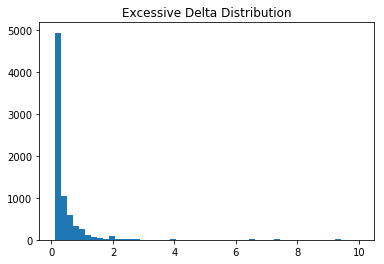

In [49]:
pl.hist(delta_2, bins=50, range=(0.1, 10));
pl.title('Excessive Delta Distribution');

Теперь посмотрю, станет ли лучше в регрессии от факторизированных значений.

### Модель 4

In [55]:
y = lag4['net_shares']
y = (y - y.mean()) / y.std()

X = lag4[['log_value_fund',
       'high_value', 'med_value',
       'ticker_share_lag_1', 'ticker_share_lag_2', 'ticker_share_lag_3', 'ticker_share_lag_4',
       'net_shares_lag_1', 'net_shares_lag_2', 'net_shares_lag_3', 'net_shares_lag_4',
       'size_cat_change_qrt_lag_1', 
       'size_cat_change_up_qrt_lag_1', 'size_cat_change_qrt_lag_2',
       'size_cat_change_up_qrt_lag_2', 'size_cat_change_qrt_lag_3',
       'size_cat_change_up_qrt_lag_3', 'size_cat_change_qrt_lag_4',
       'size_cat_change_up_qrt_lag_4', 'size_cat_change_qrt',
       'size_cat_change_up_qrt', 'size_cat_change_total',
       'turnover_high', 'turnover_med', 'turnover_low',
       'hhi_high', 'hhi_med', 'hhi_low', 'hhi_rev_high', 'hhi_rev_med',
       'hhi_rev_low', 'hhi_eq_1', 'tvr_eq_1', 'high_hhi',
       'high_turnover', 'extreme_turnover', 
       'cluster_hhi', 'cluster_turnover', 'pos_count',
       'extreme_pos_count', 'high_pos_count', 'med_pos_count', 'up_low_pos_count',
       'cluster_size_pos', 'cluster_pos_hhi', 'mean_net_shares', 'mean_net_shares_by_cik',
       'mean_net_shares_by_value']].astype('float64')
X = sm.add_constant(X)

In [56]:
model_4 = sm.OLS(y, X).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     2603.
Date:                Sun, 06 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:11:28   Log-Likelihood:            -1.7839e+06
No. Observations:             1298404   AIC:                         3.568e+06
Df Residuals:                 1298356   BIC:                         3.568e+06
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.0034      0.017     -0.196      0.845      -0.037       0.031
log_value_fund                2.306e-05      0.001      0.024      0.981      -0.002       0.002
high_value                      -0.0040      0.009     -0.449      0.654      -0.021       0.013
med_value                       -0.0025      0.008     -0.294      0.769      -0.019       0.014
ticker_share_lag_1              -0.2878      0.086     -3.359      0.001      -0.456      -0.120
ticker_share_lag_2               0.0931      0.105      0.887      0.375      -0.113       0.299
ticker_share_lag_3               0.0539      0.106      0.508      0.612      -0.154       0.262
ticker_share_lag_4               0.1363      0.084      1.616      0.106      -0.029       0.302
net_shares_lag_1             -5.604e-06    1.7e-06     -3.293      0.001   -8.94e-06   -2.27e-06
net_shares_lag_2             -8.559e-06   3.68e-06     -2.326      0.020   -1.58e-05   -1.35e-06
net_shares_lag_3              7.265e-06   2.45e-06      2.963      0.003    2.46e-06    1.21e-05
net_shares_lag_4              1.788e-05   2.44e-06      7.319      0.000    1.31e-05    2.27e-05
size_cat_change_qrt_lag_1       -0.0186      0.013     -1.441      0.150      -0.044       0.007
size_cat_change_up_qrt_lag_1    -0.0090      0.014     -0.655      0.512      -0.036       0.018
size_cat_change_qrt_lag_2       -0.0073      0.012     -0.592      0.554      -0.032       0.017
size_cat_change_up_qrt_lag_2     0.0151      0.013      1.130      0.258      -0.011       0.041
size_cat_change_qrt_lag_3       -0.0113      0.013     -0.892      0.372      -0.036       0.014
size_cat_change_up_qrt_lag_3    -0.0051      0.014     -0.378      0.706      -0.032       0.021
size_cat_change_qrt_lag_4       -0.0167      0.012     -1.353      0.176      -0.041       0.007
size_cat_change_up_qrt_lag_4    -0.0093      0.013     -0.729      0.466      -0.034       0.016
size_cat_change_qrt              0.0013      0.013      0.102      0.919      -0.024       0.027
size_cat_change_up_qrt          -0.0035      0.015     -0.243      0.808      -0.032       0.025
size_cat_change_total            0.0260      0.007      3.554      0.000       0.012       0.040
turnover_high                   -0.0054      0.008     -0.635      0.525      -0.022       0.011
turnover_med                     0.0069      0.014      0.509      0.611      -0.020       0.033
turnover_low                    -0.0083      0.014     -0.580      0.562      -0.036       0.020
hhi_high                        -0.0067      0.036     -0.188      0.851      -0.076       0.063
hhi_med                          0.0700      0.045      1.565      0.118      -0.018       0.158
hhi_low                          0.0183      0.048      0.379      0.705    

Не стало. Никаких изменений в лучшую сторону.

Теперь построим модель с макроиндикаторами!

### Модель 6

In [64]:
y = lag4['net_shares']
y = (y - y.mean()) / y.std()

X = lag4[['log_value_fund',
       'high_value', 'med_value',
       'ticker_share_lag_1', 'ticker_share_lag_2', 'ticker_share_lag_3', 'ticker_share_lag_4',
       'net_shares_lag_1', 'net_shares_lag_2', 'net_shares_lag_3', 'net_shares_lag_4',
       'size_cat_change_qrt_lag_1', 
       'size_cat_change_up_qrt_lag_1', 'size_cat_change_qrt_lag_2',
       'size_cat_change_up_qrt_lag_2', 'size_cat_change_qrt_lag_3',
       'size_cat_change_up_qrt_lag_3', 'size_cat_change_qrt_lag_4',
       'size_cat_change_up_qrt_lag_4', 'size_cat_change_qrt',
       'size_cat_change_up_qrt', 'size_cat_change_total',
       'turnover_high', 'turnover_med', 'turnover_low',
       'hhi_high', 'hhi_med', 'hhi_low', 'hhi_rev_high', 'hhi_rev_med',
       'hhi_rev_low', 'hhi_eq_1', 'tvr_eq_1', 'high_hhi',
       'high_turnover', 'extreme_turnover', 
       'cluster_hhi', 'cluster_turnover', 'pos_count',
       'extreme_pos_count', 'high_pos_count', 'med_pos_count', 'up_low_pos_count',
       'cluster_size_pos', 'cluster_pos_hhi', 'mean_net_shares', 'mean_net_shares_by_cik',
       'mean_net_shares_by_value', 'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [65]:
model_6 = sm.OLS(y, X).fit()
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     2353.
Date:                Sun, 06 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:20:33   Log-Likelihood:            -1.7839e+06
No. Observations:             1298404   AIC:                         3.568e+06
Df Residuals:                 1298351   BIC:                         3.569e+06
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.0166      0.025     -0.660      0.509      -0.066       0.033
log_value_fund                3.273e-05      0.001      0.034      0.973      -0.002       0.002
high_value                      -0.0040      0.009     -0.456      0.648      -0.021       0.013
med_value                       -0.0025      0.008     -0.300      0.764      -0.019       0.014
ticker_share_lag_1              -0.2876      0.086     -3.357      0.001      -0.455      -0.120
ticker_share_lag_2               0.0929      0.105      0.884      0.376      -0.113       0.299
ticker_share_lag_3               0.0540      0.106      0.508      0.612      -0.154       0.262
ticker_share_lag_4               0.1363      0.084      1.616      0.106      -0.029       0.302
net_shares_lag_1             -5.591e-06    1.7e-06     -3.285      0.001   -8.93e-06   -2.25e-06
net_shares_lag_2             -8.587e-06   3.68e-06     -2.333      0.020   -1.58e-05   -1.37e-06
net_shares_lag_3              7.291e-06   2.45e-06      2.973      0.003    2.48e-06    1.21e-05
net_shares_lag_4               1.79e-05   2.44e-06      7.325      0.000    1.31e-05    2.27e-05
size_cat_change_qrt_lag_1       -0.0187      0.013     -1.448      0.148      -0.044       0.007
size_cat_change_up_qrt_lag_1    -0.0088      0.014     -0.644      0.520      -0.036       0.018
size_cat_change_qrt_lag_2       -0.0072      0.012     -0.580      0.562      -0.031       0.017
size_cat_change_up_qrt_lag_2     0.0150      0.013      1.121      0.262      -0.011       0.041
size_cat_change_qrt_lag_3       -0.0115      0.013     -0.904      0.366      -0.036       0.013
size_cat_change_up_qrt_lag_3    -0.0050      0.014     -0.372      0.710      -0.032       0.021
size_cat_change_qrt_lag_4       -0.0167      0.012     -1.352      0.176      -0.041       0.007
size_cat_change_up_qrt_lag_4    -0.0093      0.013     -0.729      0.466      -0.034       0.016
size_cat_change_qrt              0.0012      0.013      0.088      0.930      -0.024       0.027
size_cat_change_up_qrt          -0.0035      0.015     -0.238      0.812      -0.032       0.025
size_cat_change_total            0.0260      0.007      3.560      0.000       0.012       0.040
turnover_high                   -0.0054      0.008     -0.636      0.525      -0.022       0.011
turnover_med                     0.0069      0.014      0.512      0.609      -0.020       0.033
turnover_low                    -0.0081      0.014     -0.566      0.571      -0.036       0.020
hhi_high                        -0.0065      0.036     -0.182      0.855      -0.076       0.063
hhi_med                          0.0701      0.045      1.568      0.117      -0.018       0.158
hhi_low                          0.0183      0.048      0.380      0.704    

Все индикаторы незначимы!!!! Зависимости даже на сломанной модели не поменялись!!!

Наблюдается отрицательная зависимость от безработицы, положительная от инфляции и отрицательная от роста ВВП.
Первая зависимость интиутивно понятно. Низкая безработица свидетельствует о росте экономики, который наблюдается последнее время, а во время роста увеличиваются вложения в финансовые активы. Если рост вызван увеличением предложения, то ещё более очевидно, что улучшение ситуации у эмитентов делает их более привлекательным.

Вторая и третья зависимость не так очевидна, но у меня есть объяснение. Увеличение инфляции и падение выпуска происходит при уменьшении совокупного предложения. Это говорит об ухудшении положении эмитентов. Тем не менее, стоит вспомнить про то, что бизнес-циклы неотъемлемая часть экономики. И в такой ситуации очевидно наблюдается спад. Мы знаем, как и все, что после спада наступает рост. А во время роста (см. абзац выше) увеличивается спрос на финансовые активы и, как следствие, цена на них. Значит, инвестор может купить акции сейчас дешевле и продать их во время бума подороже. Наверно, так можно объяснить эти коэффициенты.

Положительная зависимость от ключевой ставки объясняется тем, что увеличение ставки может быть представлено как контр-мера против перегревания экономики во время экономического бума, а поведение во время бума я уже описывал.

Если надо, то я могу воспользоваться IS-LM моделью, чтобы более подробно попытаться объяснить зависимость и логику.

И в конце я внедрю в модель факторизированные макроиндикаторы.

## Мы не можем жить без ~~космоса~~ факторизации

### Модель 7

In [69]:
y = lag4['net_shares']
y = (y - y.mean()) / y.std()

X = lag4[['log_value_fund',
       'high_value', 'med_value',
       'ticker_share_lag_1', 'ticker_share_lag_2', 'ticker_share_lag_3', 'ticker_share_lag_4',
       'net_shares_lag_1', 'net_shares_lag_2', 'net_shares_lag_3', 'net_shares_lag_4',
       'size_cat_change_qrt_lag_1', 
       'size_cat_change_up_qrt_lag_1', 'size_cat_change_qrt_lag_2',
       'size_cat_change_up_qrt_lag_2', 'size_cat_change_qrt_lag_3',
       'size_cat_change_up_qrt_lag_3', 'size_cat_change_qrt_lag_4',
       'size_cat_change_up_qrt_lag_4', 'size_cat_change_qrt',
       'size_cat_change_up_qrt', 'size_cat_change_total',
       'turnover_high', 'turnover_med', 'turnover_low',
       'hhi_high', 'hhi_med', 'hhi_low', 'hhi_rev_high', 'hhi_rev_med',
       'hhi_rev_low', 'hhi_eq_1', 'tvr_eq_1', 'high_hhi',
       'high_turnover', 'extreme_turnover', 
       'cluster_hhi', 'cluster_turnover', 'pos_count',
       'extreme_pos_count', 'high_pos_count', 'med_pos_count', 'up_low_pos_count',
       'cluster_size_pos', 'cluster_pos_hhi', 'mean_net_shares', 'mean_net_shares_by_cik',
       'mean_net_shares_by_value', 
        'DGS10_high', 'DGS10_med', 'DGS10_low', 'DFF_high', 'DFF_med', 'DFF_low', 'UNRATE_high',
        'UNRATE_med', 'UNRATE_low', 'CPIAUCSL_high', 'CPIAUCSL_med',
        'CPIAUCSL_low', 'GDP_high', 'GDP_med', 'GDP_low']].astype('float64')
X = sm.add_constant(X)

In [70]:
model_7 = sm.OLS(y, X).fit()
model_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     1973.
Date:                Sun, 06 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:22:50   Log-Likelihood:            -1.7839e+06
No. Observations:             1298404   AIC:                         3.568e+06
Df Residuals:                 1298341   BIC:                         3.569e+06
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.0614      0.061     -1.007      0.314      -0.181       0.058
log_value_fund               -3.834e-06      0.001     -0.004      0.997      -0.002       0.002
high_value                       0.0678      0.063      1.079      0.280      -0.055       0.191
med_value                       -0.0713      0.077     -0.929      0.353      -0.222       0.079
ticker_share_lag_1              -0.2880      0.086     -3.362      0.001      -0.456      -0.120
ticker_share_lag_2               0.0926      0.105      0.882      0.378      -0.113       0.298
ticker_share_lag_3               0.0533      0.106      0.502      0.616      -0.155       0.262
ticker_share_lag_4               0.1372      0.084      1.627      0.104      -0.028       0.302
net_shares_lag_1             -5.612e-06    1.7e-06     -3.297      0.001   -8.95e-06   -2.28e-06
net_shares_lag_2             -8.682e-06   3.68e-06     -2.358      0.018   -1.59e-05   -1.47e-06
net_shares_lag_3              7.348e-06   2.45e-06      2.995      0.003    2.54e-06    1.22e-05
net_shares_lag_4              1.795e-05   2.44e-06      7.344      0.000    1.32e-05    2.27e-05
size_cat_change_qrt_lag_1       -0.0191      0.013     -1.475      0.140      -0.044       0.006
size_cat_change_up_qrt_lag_1    -0.0085      0.014     -0.615      0.539      -0.035       0.019
size_cat_change_qrt_lag_2       -0.0074      0.012     -0.597      0.550      -0.032       0.017
size_cat_change_up_qrt_lag_2     0.0148      0.013      1.104      0.270      -0.011       0.041
size_cat_change_qrt_lag_3       -0.0112      0.013     -0.880      0.379      -0.036       0.014
size_cat_change_up_qrt_lag_3    -0.0051      0.014     -0.376      0.707      -0.032       0.021
size_cat_change_qrt_lag_4       -0.0176      0.012     -1.426      0.154      -0.042       0.007
size_cat_change_up_qrt_lag_4    -0.0083      0.013     -0.654      0.513      -0.033       0.017
size_cat_change_qrt              0.0009      0.013      0.068      0.946      -0.025       0.026
size_cat_change_up_qrt          -0.0036      0.015     -0.246      0.805      -0.032       0.025
size_cat_change_total            0.0262      0.007      3.582      0.000       0.012       0.041
turnover_high                   -0.0044      0.008     -0.525      0.600      -0.021       0.012
turnover_med                     0.0066      0.014      0.488      0.626      -0.020       0.033
turnover_low                    -0.0077      0.014     -0.534      0.593      -0.036       0.021
hhi_high                        -0.0062      0.036     -0.174      0.862      -0.076       0.063
hhi_med                          0.0727      0.045      1.626      0.104      -0.015       0.160
hhi_low                          0.0185      0.048      0.382      0.702    

Отмечу, что опять почти все макроиндикаторы незначимы. 

Заметим, что несмотря на свою красоту эта модель, как и предыдущие, имеет маленький R^2, то есть, имеет маленькую предсказательную способность и мало объясняет дисперсию изменения.
Но мы уже видели, что дисперсия так рознится из-за проблемы с малыми фондами и проблемы масштаба.

Главное, что наша модель имеет <b>прикладной и экономический смысл</b>!

# Сохранение датасета.

Для удобства сохраню полученные результаты.

In [71]:
import pickle

# сохраняю полный датасет
with open('final_df.pkl', 'wb') as f:
    pickle.dump(final_df, f, protocol=-1)

# Планируемая работа

1. Усовершенствовать чистку исходных данных, так как сейчас она примитивна.

    Как минимум, стоит учесть поправки к исходным отчетам, но пока непонятен их характер. Там присутствуют поправки только по активам, которых не было в исходном отчете, или же там есть поправки по активам, которые уже были упомянуты. Можно создать индикатор того, что актив был в поправках, кстати.<br><br> (Как-то справились)<br><br>
   
2. Выгрузить названия фондов из EDGAR и через Thomas Reuters сопоставить им их стили инвестирования, через что можно было бы определить схожие фонды. Потом можно было бы вычислить, например, среднее изменение актива по схожим фондам или составить кросс-произведение с другими индикаторами.<br><br> (Черт знает, где искать типы фондов)<br><br>

3. Аналогичная ситуация с акциями. Для них можно получить их индустрию. В сущности, можно тоже вычислить схожие фонды по их выбору индустрий. Также можно добавить фичи принадлежности акции индустрии, указать изменение позиции фонда по индустрии и долю индустрии в фонде. Кроме того, можно посчитать HHI и Turnover не в разрезе акций, а в разрезе индустрий. Можно сделать много новых индикаторов, посмотреть на совместное распределение HHI и Turnover с размером фонда.<br><br> (Не хватает данных)<br><br>

4. Понять, надо ли оставлять в данных, на которых я буду тренировать бустинги, леса и прочие чудеса, кросс-произведения дохода и других непрерывных переменных или достаточно будет использовать все переменные по отдельности, ведь всех можно применить PolynomialFeatures.<br><br> (Разобрались)<br><br>

5. Понять, как лучше разделять данные на тест и трейн.<br><br> <b>(Непонятно)</b><br><br>

6. Как делать датасет для определения выхода из тикера, если это слишком ресурнозатратное по памяти испытание?<br><br>

7. Нормально, что я в регрессии использую и HHI, и обратный HHI?<br><br>

the coursework will return ...